<a href="https://colab.research.google.com/github/wonderalexandre/MorphoTreeAdjust/blob/main/notebooks/morphoTreeAdjust_example_subtree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Theoretical considerations

**Characterization of the Subtree $S$**

- Let $S_\text{root}$ be a node of ${T}^{min}_{f}$.
- We define the subtree $S$ as: $S = \{\tau \in {T}^{min}_{f} \mid \tau \subseteq S_{\text{root}} \}$.
- Note that the flatezones present in $S$ constitute a partition of the connected component $S_\text{root}$.

**Definition of the Corresponding Max-Tree Nodes**
- We define the set of max-tree nodes corresponding to $S$ as:
$$
\tau_S = \{ \text{flat}({{T}^{max}_{f}, p}) \mid p \in S_\text{root} \}
$$

- We define $\tau^{\star}$ as the node in $\tau_S$ with the **highest** gray-level value:
$$
\tau^{\star} = \arg\max_{\tau \in \tau_S}\{ \text{level}({T}^{max}_{f}, \tau) \}
$$

**Definition of the Interval [a, b]**

- We define the interval $[a, b]$ as:
    - $a = \text{level}({T}^{max}_{f}, \tau^{\star})$
    - $b = \text{level}({T}^{min}_{f}, \text{Parent}( S_\text{root} ))$

**Definitions of collections $F_\lambda$ and $F_{\lambda > b}$**

Previously, we defined the sets $F_\lambda$ and $F_{\lambda > b}$ in terms of nodes in ${T}^{max}_{f}$ whose gray levels fall within the interval $[a, b]$ and that are $\alpha$-connected to the leaf $L$.
Now,
- $F_\lambda$ contains all nodes in $\tau_S$ that are $\alpha$-connected to a flat zone of $S$ and have level $a \leq \lambda \leq b$.
- $F_{\lambda > b}$ contains nodes of ${T}^{max}_{f}$ whose levels are greater than $b$ and are $\alpha$-connected to a flat zone of $S$.

**Node updating**

- When $\lambda = b$, we merge the set $F_b$ with all flat zones present in the subtree $S$, forming the new node:
$$
\tau_b = S \cup \bigcup F_b \cup \bigcup F_{\lambda > b}
$$

   > However, this operation can lead to the **extinction of some nodes** in  $F_{\lambda}$.
    Specifically: if a node $\tau \in F_{\lambda} \cap \tau_S$, (with $\lambda \neq b$), has all its cnps is merged into $\tau_b$, then $\tau$ ceases to exist as an individual node in ${T}^{min}_{g}$.
    
- When $a+1 \leq \lambda \leq b-1$ is same but consider into account if the node has been extinguished.

- When $\lambda = a$ we have $\tau_a = \tau^{\star}$.

**Edges updating**
- Similarly, but consider if the node has been extinguished.

# 1. Install Library

In [ ]:
!pip install morphoTreeAdjust
!pip install PrettyPrintTree

In [2]:
import sys
sys.path.append("/opt/anaconda3/lib")

# 2. Importing library and defining plotting functions

In [5]:
# @title
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import morphoTreeAdjust as mta

from PrettyPrint import PrettyPrintTree
from colorama import Fore, Back

printTree = PrettyPrintTree(
    lambda node: node.children,
    lambda node: (str(node.id) + ": " +str(node.level) +": " +str((node.area))), color=Back.BLACK + Fore.WHITE,
    start_message=lambda node: f'Each node is represented by <index>: <gray level>: |cnps|\n'
)

def showLevelSets(img_f):
    print("Upper and lower level sets where in the black (highlighted are cnps) are foreground pixels and white are background pixels")
    t_values = np.unique(img_f)
    len = np.size(t_values)
    max_value = np.max(img_f)
    fig, axes = plt.subplots(len, 2, figsize=(5, 15))

    # Preenchendo os subplots com imagens limiares
    for i, t in enumerate(t_values):
        # Primeira coluna: img_f >= t
        thr = t_values[i]
        img_threshold_ge = np.where(img_f > thr, 1, 0)
        img_threshold_cnps = np.where(img_f == thr, 1, 0)

        axes[i, 0].imshow(img_threshold_ge, cmap='gray_r', vmax=1, vmin=0, interpolation='nearest')
        axes[i, 0].imshow(img_threshold_cnps, cmap='gray_r', vmax=1, vmin=0, alpha=0.4, interpolation='nearest')
        axes[i, 0].set_title(f'image ≥ {t}')
        axes[i, 0].axis('off')
        axes[i, 0].add_patch(plt.Rectangle((0, 0), img_threshold_ge.shape[1] - 1, img_threshold_ge.shape[0] - 1,
                                   edgecolor='red', linewidth=0.5, fill=False))
        # Segunda coluna: img_f <= t
        thr = t_values[len - i -1]
        img_threshold_le = np.where(img_f < thr, 1, 0)
        img_threshold_cnps = np.where(img_f == thr, 1, 0)
        axes[i, 1].imshow(img_threshold_le, cmap='gray_r',vmax=1, vmin=0, interpolation='nearest')
        axes[i, 1].imshow(img_threshold_cnps, cmap='gray_r', vmax=1, vmin=0, alpha=0.4, interpolation='nearest')
        axes[i, 1].set_title(f'image ≤ {thr}')
        axes[i, 1].axis('off')
        axes[i, 1].add_patch(plt.Rectangle((0, 0), img_threshold_le.shape[1] - 1, img_threshold_le.shape[0] - 1,
                                   edgecolor='blue', linewidth=0.5, fill=False))

    # Ajuste de layout para evitar sobreposição
    plt.tight_layout()
    plt.show()


def computeCentroid(cnps):
    closest_pixel = cnps[len(cnps)//2]
    px, py = closest_pixel // num_cols, closest_pixel % num_cols
    return px, py

def showTree(tree):
    if(tree.isMaxtree):
        print("Imagem and its max-tree representation. The indexes of max-tree nodes are shown as label in the imagem.")
    else:
        print("Imagem and its min-tree representation. The indexes of min-tree nodes are shown as label in the imagem.")
    img_vector = tree.reconstructionImage()
    ids_position = []

    for node in tree.root.BFSTraversal():
      px, py = computeCentroid(node.cnps)
      ids_position.append( (node.id, px, py) )

    # Plota a imagem
    plt.figure(figsize=(8, 6))
    image = img_vector.reshape(tree.numRows, tree.numCols)
    # Adicionando uma borda ao redor da imagem
    ax = plt.gca()  # Obtém o eixo atual
    ax.add_patch(plt.Rectangle((0, 0), image.shape[1] - 1, image.shape[0] - 1,
                               edgecolor='red', linewidth=0.5, fill=False))

    plt.imshow(image, cmap='gray')

    # Adiciona rótulos nos centróides fictícios
    for i, (id, x, y) in enumerate(ids_position):
        plt.text(y, x, f'•{id}', color='red', fontsize=9)


    plt.axis('off')
    plt.show()
    printTree(tree.root)

def showNode(tree, node, showCNPs=True):
    image = tree.reconstructionNode(node).reshape(num_rows, num_cols)
    ax = plt.gca()  # Obtém o eixo atual
    ax.imshow(image, cmap='gray_r')
    ax.add_patch(plt.Rectangle((0, 0), image.shape[1] - 1, image.shape[0] - 1,
                               edgecolor='red', linewidth=0.5, fill=False))
    if showCNPs:
        for p in node.cnps:
            row, col = divmod(p, num_cols)  # Converter índice linear para coordenadas 2D
            ax.scatter(col, row, color='red', s=5)


    ax.set_title(f"{node}")
    ax.axis("off")

def buildMapIds(tree):
    mapIds = np.zeros(num_rows*num_cols)
    for p in range(num_rows*num_cols):
        mapIds[p] = tree.getSC(p).id
    return mapIds


import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

def getNodeContour(tree, node):
    adj = mta.AdjacencyRelation(num_rows, num_cols, 1.5)  # Relação de adjacência
    contour = []

    for idP in node.cnps:  # Percorre os pixels do nó
        for idQ in adj.getAdjPixels(idP):  # Verifica seus vizinhos
            sc_p = tree.getSC(idP)
            sc_q = tree.getSC(idQ)

            if sc_p.id != sc_q.id:  # Verifica se são nós diferentes
                pixel_x = idQ // num_cols
                pixel_y = idQ % num_cols
                contour.append((pixel_y, pixel_x))  # (x=coluna, y=linha)

    return contour



def showNodesOfSubtree(tree, root):
    image = tree.reconstructionImage().reshape(num_rows, num_cols)
    adj = mta.AdjacencyRelation(num_rows, num_cols, 1.5)
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')

    # Desenha a borda do retângulo em vermelho
    ax.add_patch(patches.Rectangle((0, 0), image.shape[1] - 1, image.shape[0] - 1,
                                   edgecolor='red', linewidth=0.5, fill=False))

    colormap = plt.colormaps['Paired']  # Obtém a paleta de cores (versão compatível)
    ids_position = []
    map_adj = {}

    for node in root.BFSTraversal():
        contours_x = []
        contours_y = []
        color = colormap(node.id % 10)  # Seleciona cor baseada no ID do nó

        # Obtém um ponto de referência do nó para exibir seu ID
        (px, py) = computeCentroid(node.cnps)
        ids_position.append((node.id, px, py, color))

        contour = getNodeContour(tree, node)
        if contour:
            contour_x, contour_y = zip(*contour) if contour else ([], [])
            ax.scatter(contour_x, contour_y, color=color, s=0.5, label=f"Node {node.id}")

        for idP in node.cnps:
            for idQ in adj.getAdjPixels(idP):
                sc_p = tree.getSC(idP)
                sc_q = tree.getSC(idQ)
                if sc_p and sc_q and sc_p.id != sc_q.id:
                    if idQ not in map_adj:
                        nodeQ = sc_q
                        (qx, qy) = computeCentroid(nodeQ.cnps)
                        map_adj[idQ] = (nodeQ.id, qx, qy)




    # Plota os IDs dos nós vizinhos (em vermelho)
    for node_id, x, y in map_adj.values():
        plt.text(y, x, f'{node_id}', color='red', fontsize=9)

    # Plota os IDs dos nós no centro
    for node_id, x, y, color in ids_position:
        plt.text(y, x, f'•{node_id}•', color=color, fontsize=9)


    ax.set_title(f"Corresponding max-tree nodes and their neighbors")
    ax.axis("off")  # Remove os eixos
    plt.show()


# 3. Creating the mintree and maxtree of an input image

- Image of the JMIV paper

Upper and lower level sets where in the black (highlighted are cnps) are foreground pixels and white are background pixels


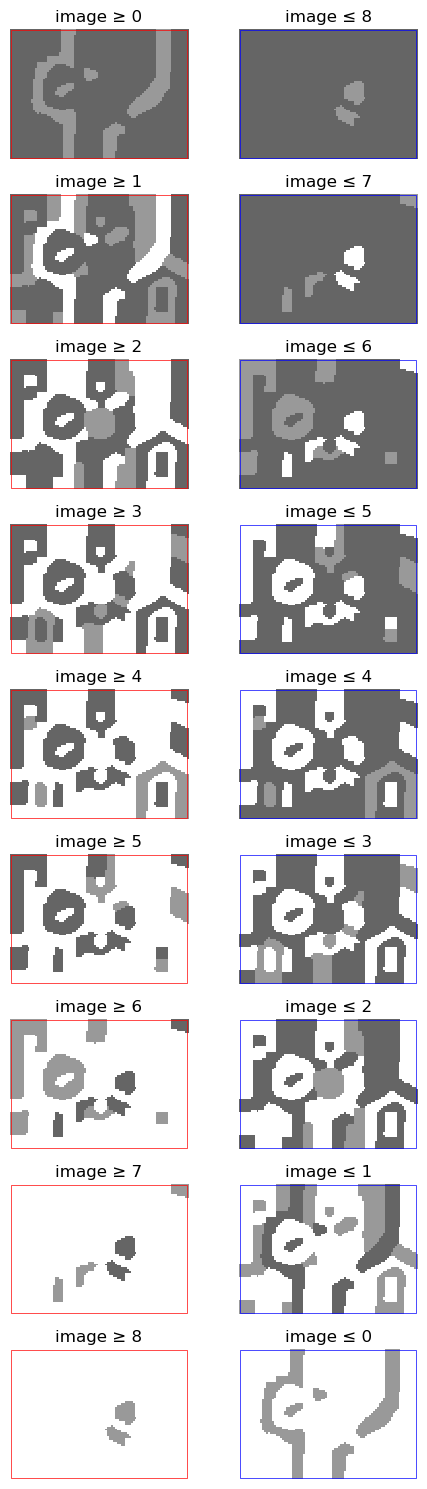




Imagem and its min-tree representation. The indexes of min-tree nodes are shown as label in the imagem.


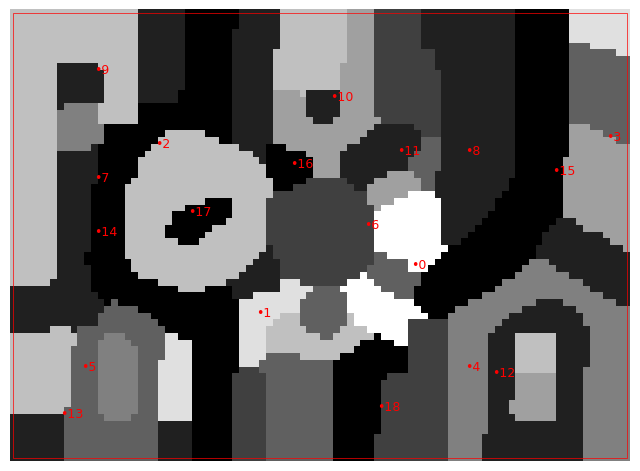

Each node is represented by <index>: <gray level>: |cnps|

                                                                                                 0: 8: 6164 
                                                                                                     |
                                                                                                 1: 7: 5998 
                                                                                                     |
                                                                                                 2: 6: 5818 
                                                                                       ┌─────────────┴──────────────┐
                                                                                   3: 5: 4633                   17: 0: 44 
                                                                      ┌────────────────┴────────────────┐                 
                                            

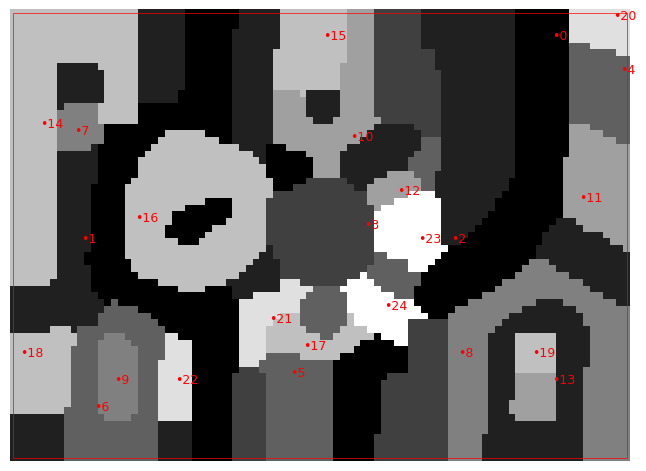

Each node is represented by <index>: <gray level>: |cnps|

                                                                      0: 0: 6164 
                            ┌─────────────────────────────────────────────┴──────────────────────────────────────────────┐
                        1: 1: 1353                                                                                   2: 1: 3638                                 
                ┌───────────┴────────────┐                                               ┌───────────────────────────────┴─────────────┬──────────────────┐     
            6: 3: 464                7: 4: 474                                       3: 2: 2261                                    4: 3: 311          13: 5: 80 
    ┌───────────┼────────────┐           |                     ┌─────────────────────────┴─┬───────────┬────────────┐            ┌─────┴──────┐           |     
 9: 4: 72   18: 6: 112   22: 7: 59   14: 6: 431            5: 3: 595                   8: 4:

In [9]:
img_jmiv = np.array([
    [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,7,7,7,7,7,7,7,7,7],
    [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,7,7,7,7,7,7,7,7,7],
    [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,7,7,7,7,7,7,7,7,7],
    [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,7,7,7,7,7,7,7,7,7],
    [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,7,7,7,7,7,7,7,7,7],
    [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,7,7,7,7,7,7],
    [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,6,5,5,5,5,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,7,7],
    [6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,6,5,5,5,5,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,6,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,5,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,1,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,5,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,1,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,5,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,1,6,6,6,6,6,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,6,6,6,6,6,6,6,6,6,6,5,5,5,5,5,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,1,6,6,6,6,6,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,5,5,5,5,6,1,1,1,1,1,5,5,5,5,5,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,1,6,6,6,6,6,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,5,5,5,5,5,1,1,1,1,1,5,5,5,5,5,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,1,4,4,4,4,4,6,6,6,6,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,5,5,5,5,5,1,1,1,1,1,5,5,5,5,5,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,4,4,4,4,4,4,6,6,6,6,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,5,5,5,5,5,1,1,1,1,1,5,5,5,5,5,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,4,4,4,4,4,4,6,6,6,6,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,5,5,5,5,5,5,1,1,1,5,5,5,5,5,5,5,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,4,4,4,4,4,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,1,1,1,1,1,1,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,5,5,5,3,3,3,3,3,3],
    [6,6,6,6,6,6,6,4,4,4,4,4,4,4,0,0,0,0,0,0,0,0,0,6,6,6,6,6,6,0,0,0,0,1,1,1,1,1,1,5,5,5,5,5,5,5,5,5,5,5,5,5,5,1,1,1,1,1,1,1,1,2,2,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,5,5,5,5,5,3,3,3,3],
    [6,6,6,6,6,6,6,4,4,4,4,4,4,4,0,0,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,0,0,1,1,1,1,1,1,5,5,5,5,5,5,5,5,5,5,5,5,5,1,1,1,1,1,1,1,1,1,3,3,3,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,3,3],
    [6,6,6,6,6,6,6,4,4,4,4,4,1,0,0,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,0,0,0,5,5,5,5,5,5,5,5,5,1,1,1,1,1,1,1,1,1,1,1,3,3,3,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,0,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,0,0,0,0,0,0,5,5,5,5,5,1,1,1,1,1,1,1,1,1,1,1,3,3,3,3,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,0,0,0,0,0,0,0,5,5,5,5,1,1,1,1,1,1,1,1,1,1,3,3,3,3,3,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,0,0,0,0,0,0,0,5,5,5,5,1,1,1,1,1,1,1,1,1,1,3,3,3,3,3,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,0,0,0,0,0,0,0,5,5,5,5,1,1,1,1,1,1,1,5,5,5,5,3,3,3,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,0,0,0,0,0,2,2,2,2,2,2,1,1,1,1,5,5,5,5,5,5,5,3,3,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,0,0,0,2,2,2,2,2,2,2,2,2,1,1,5,5,5,5,5,5,5,5,3,3,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,2,2,2,2,2,2,2,2,2,2,2,2,2,2,5,5,5,5,5,5,8,8,8,8,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,0,0,0,0,6,6,6,6,6,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,5,5,5,5,8,8,8,8,8,8,8,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,6,6,6,0,0,0,0,0,0,0,6,6,6,6,6,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,5,8,8,8,8,8,8,8,8,8,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,6,0,0,0,0,0,0,0,0,0,6,6,6,6,6,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,8,8,8,8,8,8,8,8,8,8,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,6,0,0,0,0,0,0,0,0,6,6,6,6,6,6,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,8,8,8,8,8,8,8,8,8,8,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,5,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,0,0,0,0,0,0,0,6,6,6,6,6,6,6,6,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,8,8,8,8,8,8,8,8,8,8,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,5,5,5,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,8,8,8,8,8,8,8,8,8,8,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,5,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,6,6,0,0,0,6,6,6,6,6,6,6,6,6,6,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,8,8,8,8,8,8,8,8,8,8,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,5,5,5],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,8,8,8,8,8,8,8,8,8,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,5],
    [6,6,6,6,6,6,6,1,1,1,1,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,8,8,8,8,8,8,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
    [6,6,6,6,6,6,6,1,1,1,1,0,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,8,8,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,8,8,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1],
    [6,6,6,6,6,6,6,1,1,1,1,1,0,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,8,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,1,1,1,1,1,1,1,1,1],
    [6,6,6,6,6,6,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,1,1,1,1,1,1,1,1,7,7,7,2,2,2,2,2,2,2,8,8,8,8,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,4,4,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6,6,6,6,0,0,0,0,1,1,1,1,1,1,1,7,7,7,7,7,3,3,3,3,8,8,8,8,8,8,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,7,7,7,7,7,7,7,7,3,3,3,3,3,3,8,8,8,8,8,8,8,3,3,3,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,1,1,1,1],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,7,7,7,7,7,7,7,7,3,3,3,3,3,3,3,8,8,8,8,8,8,8,8,8,8,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,1,1,1,1,4,4,4,4,4,4,4,4,1,1],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,7,7,7,7,7,7,7,7,3,3,3,3,3,3,3,8,8,8,8,8,8,8,8,8,8,8,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,1,1,1,1,1,1,1,1,4,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,7,7,7,7,7,7,6,6,6,3,3,3,3,3,3,3,6,8,8,8,8,8,8,8,8,8,8,8,0,0,0,4,4,4,4,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,7,7,7,7,7,6,6,6,6,3,3,3,3,3,3,3,6,8,8,8,8,8,8,8,8,2,2,2,2,2,2,4,4,4,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,6,6,6,1,3,3,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,7,7,7,7,6,6,6,6,6,6,3,3,3,3,3,6,6,6,6,8,8,8,8,8,8,2,2,2,2,2,2,4,4,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,3,3,3,3,3,3,7,7,0,0,0,0,0,0,0,0,0,7,7,7,7,6,6,6,6,6,6,6,6,3,3,6,6,6,6,6,6,0,8,8,8,8,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,6,6,6,6,6,6,1,1,1,1,1,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,6,3,3,3,4,4,4,4,4,3,3,3,3,3,7,7,7,7,0,0,0,0,0,0,0,7,7,7,7,6,6,6,6,6,6,6,6,6,6,6,6,6,6,0,0,0,0,0,8,8,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,6,6,6,6,6,6,1,1,1,1,1,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,4,4,4,3,3,3,3,7,7,7,7,0,0,0,0,0,0,0,7,7,7,7,6,6,6,6,6,6,6,6,6,6,6,6,6,0,0,0,0,0,0,0,0,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,6,6,6,6,6,6,1,1,1,1,1,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,4,4,4,3,3,3,3,7,7,7,7,0,0,0,0,0,0,0,7,7,7,7,3,3,3,3,3,6,6,6,6,6,6,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,6,6,6,6,6,6,1,1,1,1,1,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,4,4,4,3,3,3,7,7,7,7,7,0,0,0,0,0,0,0,7,7,7,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,6,6,6,6,6,6,1,1,1,1,1,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,4,4,4,3,3,3,7,7,7,7,7,0,0,0,0,0,0,0,2,2,2,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,6,6,6,6,6,6,1,1,1,1,4,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,4,4,4,3,3,3,7,7,7,7,7,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,5,5,5,5,5,5,1,1,1,1,4,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,4,4,4,3,3,3,7,7,7,7,7,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,5,5,5,5,5,5,1,1,1,1,4,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,4,4,4,3,3,3,7,7,7,7,7,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,5,5,5,5,5,5,1,1,1,1,4,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,4,4,4,3,3,3,7,7,7,7,7,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,5,5,5,5,5,5,1,1,1,1,4,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,6,3,3,3,3,4,4,4,4,4,4,3,3,3,7,7,7,7,7,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,5,5,5,5,5,5,5,1,1,1,1,4,4,4,4,4,4,4],
    [6,6,6,6,6,6,6,6,3,3,3,3,3,4,4,4,4,4,4,3,3,3,7,7,7,7,7,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,5,5,5,5,5,5,5,1,1,1,1,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,1,1,3,3,3,3,3,3,4,4,4,4,3,3,3,3,7,7,7,7,7,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,5,5,5,5,5,5,1,1,1,1,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,4,4,4,4,4],
    [1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,0,0,0,0,0,0,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,4,4,4,4,4],
], dtype=np.uint8)


num_rows, num_cols = img_jmiv.shape
img_jmiv_vector = img_jmiv.ravel()

graph = mta.FlatZonesGraph(img_jmiv_vector, num_rows, num_cols, 1.5)
maxtree = mta.ComponentTree(graph, True)
mintree = mta.ComponentTree(graph, False)

showLevelSets(img_jmiv)
print("\n\n")
showTree(mintree)
print("\n\n")
showTree(maxtree)


### 4.1 Selecting the subtree

Each node is represented by <index>: <gray level>: |cnps|

       7: 1: 1061 
     ┌─────┴──────┐
 14: 0: 540   16: 0: 38 


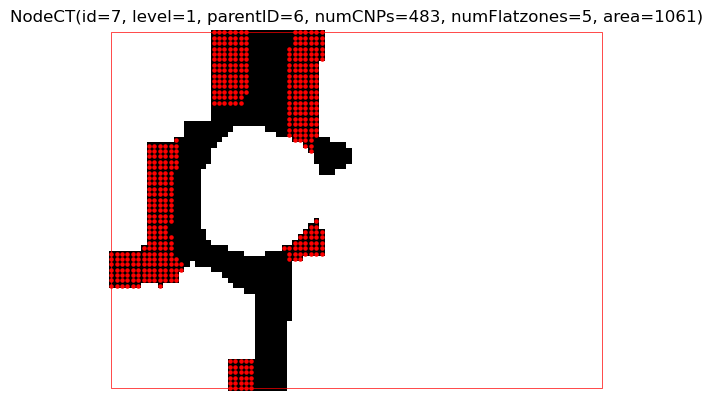

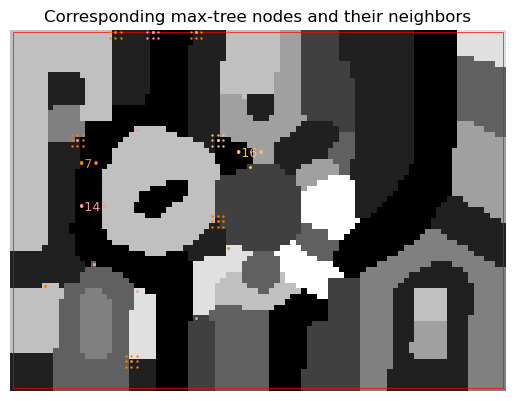

In [79]:
mapNodes = mintree.nodes()
S = mapNodes[7]

showNode(maxtree, S)
printTree(S)
showNodesOfSubtree(maxtree, S)

### 4.2 Analyzing collections $F_\lambda$ and $F_{\lambda>b}$

In [18]:
adjust = mta.ComponentTreeAdjustmentBySubtree(mintree, maxtree)

adjust.updateTree(maxtree, S)

#after, pruning the maxtree
mintree.prunning(S)
del S

print(adjust.log())

Area(rSubtree)= 1061, level(rSubtree)= 1, level(parent(rSubtree))= 2
newGrayLevel: 2
Proper parts: (Tau_S): [	(id:1, level:1, |cnps|:415, repFZ:19), 
		(id:2, level:1, |cnps|:986, repFZ:34), 
		(id:1, level:1, |cnps|:415, repFZ:1852), 
		(id:2, level:1, |cnps|:986, repFZ:3258), 
		(id:1, level:1, |cnps|:415, repFZ:5634), 
		(id:0, level:0, |cnps|:1173, repFZ:26), 
		(id:0, level:0, |cnps|:1173, repFZ:1878), 
]
Intervalo: [0, 2]
nodeTauStar: Id:0; level:0; |cnps|:1173
F_λ = { 2:[ Id:3 ] 1:[ Id:2 Id:1 ] }
F_{λ>b} = { Id:7  Id:6 }

F_{2} = 
	(Id:3; level:2; |cnps|:620) 
		After add CNPs of S: (Id:3; level:2; |cnps|:1681) 
	nodeUnion = union(F_{2}) =  id:3, level: 2, |cnps|: 1681, |children|: 6
F_{1} = 
	(Id:2; level:1; |cnps|:820) 
	(Id:1; level:1; |cnps|:98) 
	nodeUnion = union(F_{1}) =  id:2, level: 1, |cnps|: 918, |children|: 3



The reconstruction images are equals? True
Imagem and its min-tree representation. The indexes of min-tree nodes are shown as label in the imagem.


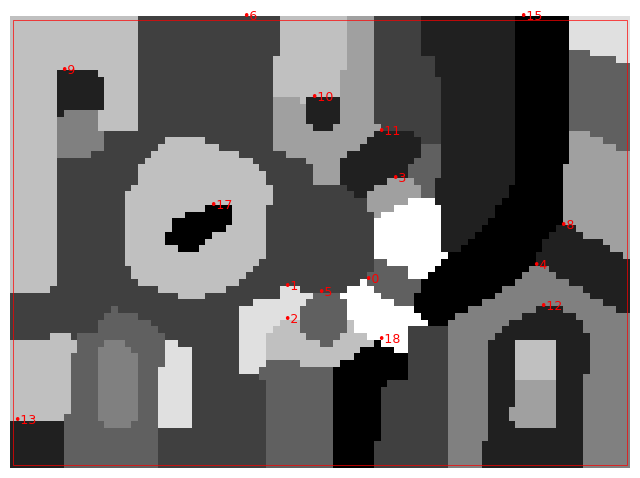

Each node is represented by <index>: <gray level>: |cnps|

                                                                         0: 8: 6164 
                                                                             |
                                                                         1: 7: 5998 
                                                                             |
                                                                         2: 6: 5818 
                                                               ┌─────────────┴─────────────┐
                                                           3: 5: 4633                  17: 0: 44 
                                                ┌──────────────┴───────────────┐                 
                                            4: 4: 4218                     10: 1: 23             
                              ┌─────────────────┴─────┬───────────┐                              
                          5: 3: 3439       

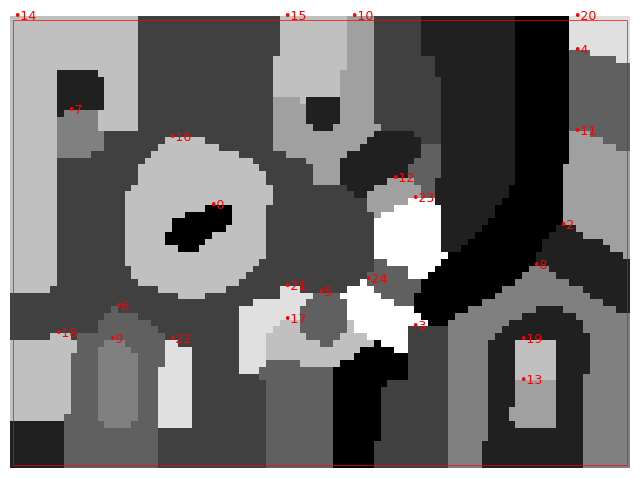

Each node is represented by <index>: <gray level>: |cnps|

                                                 0: 0: 6164 
                                                     |
                                                 2: 1: 5569 
           ┌──────────────────┬──────────────────────┴──────────────────────────────────────────┐
       4: 3: 311          13: 5: 80                                                         3: 2: 4260                                                          
     ┌─────┴──────┐           |                    ┌───────────────────────────┬───────────┬────┴───────┬────────────┬───────────────────────┐                  
 11: 5: 146   20: 7: 53   19: 6: 36            5: 3: 595                   8: 4: 378   10: 5: 295   16: 6: 373   7: 4: 474               6: 3: 464              
                                          ┌────────┴─────────┐                             |                         |           ┌───────────┼────────────┐     
                      

In [20]:
#reconstructed images of both trees
img_g_vector_maxtree = maxtree.reconstructionImage()
img_g_vector_mintree = mintree.reconstructionImage()

print("The reconstruction images are equals?", (img_g_vector_maxtree == img_g_vector_mintree).all() )

showTree(mintree)
print("\n\n")
showTree(maxtree)

# Other simple images for testing

- Example image created by Wonder

Upper and lower level sets where in the black (highlighted are cnps) are foreground pixels and white are background pixels


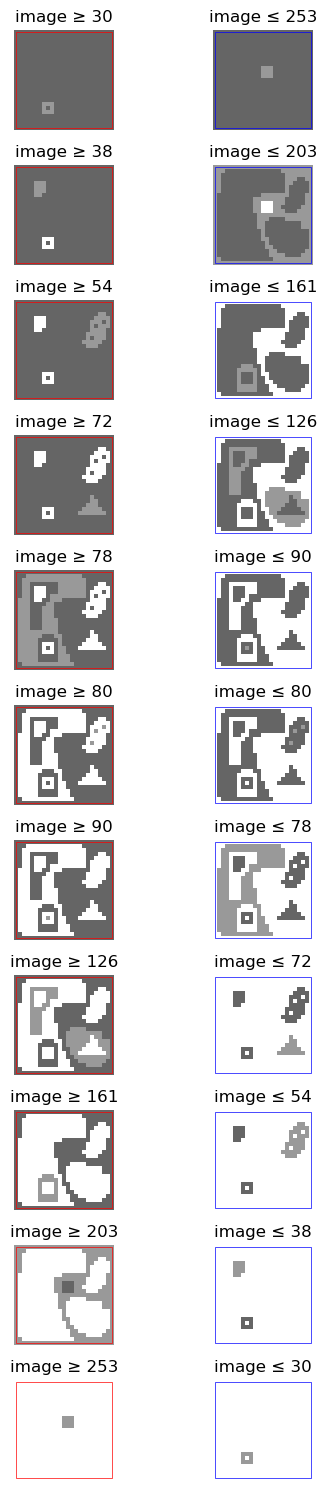

Imagem and its min-tree representation. The indexes of min-tree nodes are shown as label in the imagem.


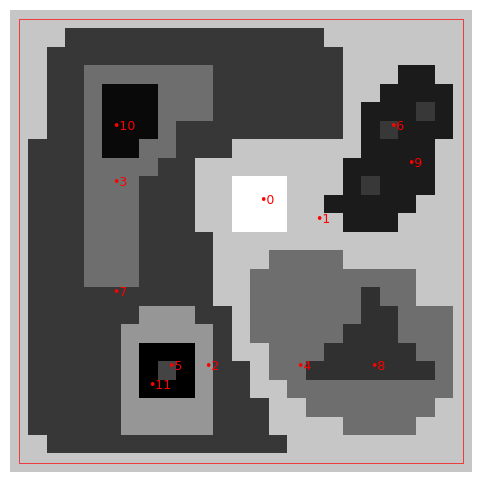

Each node is represented by <index>: <gray level>: |cnps|

                                 0: 253: 625 
                                      |
                                 1: 203: 616 
                     ┌────────────────┴────┬────────────┐
                2: 161: 277            4: 126: 84   6: 80: 38 
           ┌─────────┴─────────┐           |            |     
      3: 126: 244           5: 90: 9   8: 72: 18    9: 54: 35 
     ┌─────┴──────┐            |                              
 7: 78: 191   10: 38: 11   11: 30: 8 
Imagem and its max-tree representation. The indexes of max-tree nodes are shown as label in the imagem.


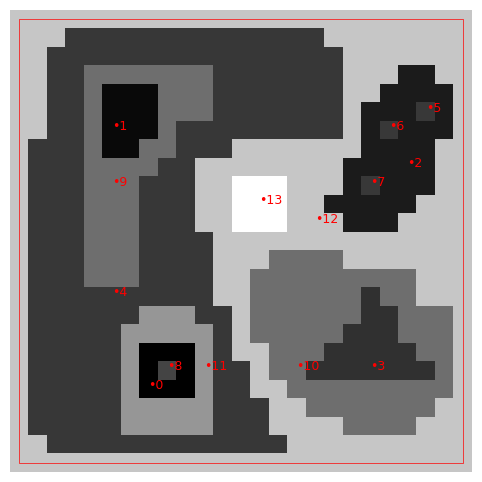

Each node is represented by <index>: <gray level>: |cnps|

                                                         0: 30: 625 
                                           ┌─────────────────┴─────────────────┐
                                       1: 38: 616                           8: 90: 1 
                                           |                                         
                                       2: 54: 605                                    
                   ┌───────────────────────┴──┬──────────┬──────────┐                
               3: 72: 567                  5: 80: 1   6: 80: 1   7: 80: 1            
                   |                                                                 
               4: 78: 549                                                            
     ┌─────────────┼──────────────┐                                                  
 9: 126: 42   10: 126: 292   11: 161: 24                                             
                 

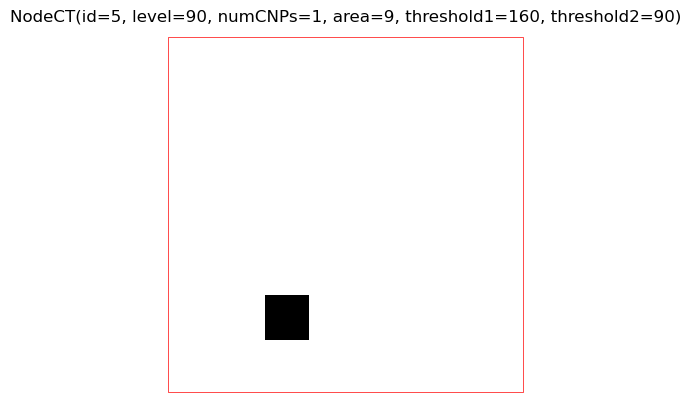

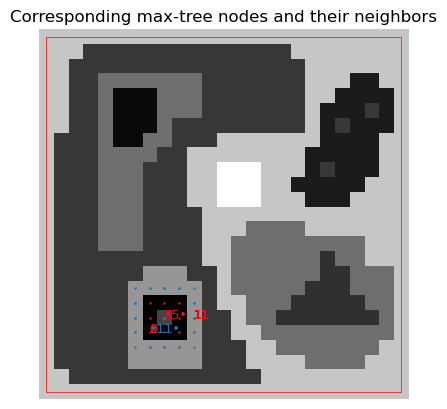

Area(rSubtree)= 9, level(rSubtree)= 90, level(parent(rSubtree))= 161
newGrayLevel: 161
unionNodes (Tau_S): [	(id:8, level:90, |cnps|:9, idFZ:483), 
		(id:0, level:30, |cnps|:0, idFZ:457), 
]
Intervalo: [30, 161]
nodeTauStar: Id:0; level:30; |cnps|:0
F_λ = { 161:[ Id:11 ] 90:[ Id:8 ] 78:[ Id:4 ] 72:[ Id:3 ] 54:[ Id:2 ] 38:[ Id:1 ] }
F_{λ>b} = {}

F_{161} = 
	(Id:11; level:161; |cnps|:24) 
		After add CNPs of S: (Id:11; level:161; |cnps|:33) 
	Nodes to be removed from tree: (id:8, level: 90, |cnps|: 0, |children|: 0), (id:0, level: 30, |cnps|: 0, |children|: 2), 
	nodeUnion = union(F_{161}) =  id:11, level: 161, |cnps|: 33, |children|: 0
F_{78} = 
	(Id:4; level:78; |cnps|:191) 
	nodeUnion = union(F_{78}) =  id:4, level: 78, |cnps|: 191, |children|: 3
F_{72} = 
	(Id:3; level:72; |cnps|:18) 
	nodeUnion = union(F_{72}) =  id:3, level: 72, |cnps|: 18, |children|: 1
F_{54} = 
	(Id:2; level:54; |cnps|:35) 
	nodeUnion = union(F_{54}) =  id:2, level: 54, |cnps|: 35, |children|: 4
F_{38} = 
	(Id:

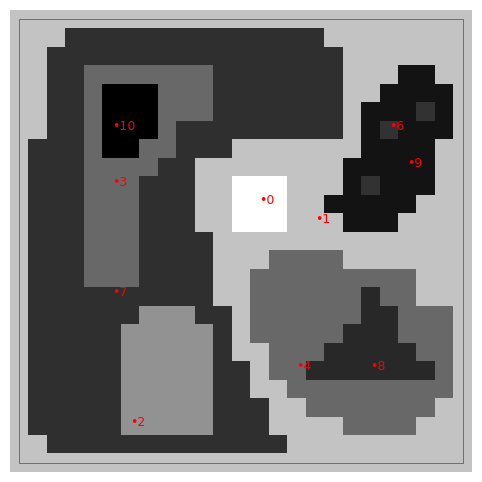

Each node is represented by <index>: <gray level>: |cnps|

                      0: 253: 625 
                           |
                      1: 203: 616 
           ┌───────────────┴───┬────────────┐
      2: 161: 277          4: 126: 84   6: 80: 38 
           |                   |            |     
      3: 126: 244          8: 72: 18    9: 54: 35 
     ┌─────┴──────┐                               
 7: 78: 191   10: 38: 11 



Imagem and its max-tree representation. The indexes of max-tree nodes are shown as label in the imagem.


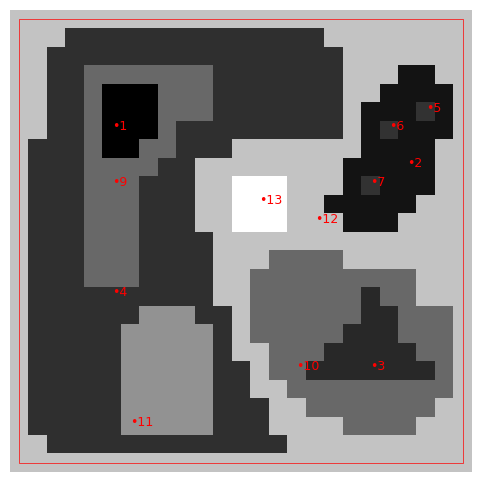

Each node is represented by <index>: <gray level>: |cnps|

                        1: 38: 625 
                            |
                        2: 54: 614 
    ┌──────────┬──────────┬─┴───────────────────────┐
 5: 80: 1   6: 80: 1   7: 80: 1                 3: 72: 576                
                                                    |                     
                                                4: 78: 558                
                                      ┌─────────────┼──────────────┐      
                                  9: 126: 42   10: 126: 292   11: 161: 33 
                                                    |                     
                                               12: 203: 226               
                                                    |                     
                                                13: 253: 9 


In [17]:
img_wonder = np.array([
[203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203],
[203,203,203, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78,203,203,203,203,203,203,203,203],
[203,203, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78,203,203,203,203,203,203,203],
[203,203, 78, 78,126,126,126,126,126,126,126, 78, 78, 78, 78, 78, 78, 78,203,203,203, 54, 54,203,203],
[203,203, 78, 78,126, 38, 38, 38,126,126,126, 78, 78, 78, 78, 78, 78, 78,203,203, 54, 54, 54, 54,203],
[203,203, 78, 78,126, 38, 38, 38,126,126,126, 78, 78, 78, 78, 78, 78, 78,203, 54, 54, 54, 80, 54,203],
[203,203, 78, 78,126, 38, 38, 38,126, 78, 78, 78, 78, 78, 78, 78, 78, 78,203, 54, 80, 54, 54, 54,203],
[203, 78, 78, 78,126, 38, 38,126,126, 78, 78, 78,203,203,203,203,203,203,203, 54, 54, 54, 54,203,203],
[203, 78, 78, 78,126,126,126,126, 78, 78,203,203,203,203,203,203,203,203, 54, 54, 54, 54, 54,203,203],
[203, 78, 78, 78,126,126,126, 78, 78, 78,203,203,253,253,253,203,203,203, 54, 80, 54, 54, 54,203,203],
[203, 78, 78, 78,126,126,126, 78, 78, 78,203,203,253,253,253,203,203, 54, 54, 54, 54, 54,203,203,203],
[203, 78, 78, 78,126,126,126, 78, 78, 78,203,203,253,253,253,203,203,203, 54, 54, 54,203,203,203,203],
[203, 78, 78, 78,126,126,126, 78, 78, 78, 78,203,203,203,203,203,203,203,203,203,203,203,203,203,203],
[203, 78, 78, 78,126,126,126, 78, 78, 78, 78,203,203,203,126,126,126,126,203,203,203,203,203,203,203],
[203, 78, 78, 78,126,126,126, 78, 78, 78, 78,203,203,126,126,126,126,126,126,126,126,126,203,203,203],
[203, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78,203,203,126,126,126,126,126,126, 72,126,126,203,203,203],
[203, 78, 78, 78, 78, 78, 78,161,161,161, 78, 78,203,126,126,126,126,126,126, 72, 72,126,126,126,203],
[203, 78, 78, 78, 78, 78,161,161,161,161,161, 78,203,126,126,126,126,126, 72, 72, 72,126,126,126,203],
[203, 78, 78, 78, 78, 78,161, 30, 30, 30,161, 78,203,203,126,126,126, 72, 72, 72, 72, 72,126,126,203],
[203, 78, 78, 78, 78, 78,161, 30, 90, 30,161, 78, 78,203,126,126, 72, 72, 72, 72, 72, 72, 72,126,203],
[203, 78, 78, 78, 78, 78,161, 30, 30, 30,161, 78, 78,203,203,126,126,126,126,126,126,126,126,126,203],
[203, 78, 78, 78, 78, 78,161,161,161,161,161, 78, 78, 78,203,203,126,126,126,126,126,126,126,203,203],
[203, 78, 78, 78, 78, 78,161,161,161,161,161, 78, 78, 78,203,203,203,203,126,126,126,126,203,203,203],
[203,203, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78,203,203,203,203,203,203,203,203,203,203],
[203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203,203]
], dtype=np.uint8)

num_rows, num_cols = img_wonder.shape
img_wonder_vector = img_wonder.ravel()

graph = mta.FlatZonesGraph(img_wonder_vector, num_rows, num_cols, 1.5)
maxtree = mta.ComponentTree(graph, True)
mintree = mta.ComponentTree(graph, False)

showLevelSets(img_wonder)
showTree(mintree)
showTree(maxtree)




mapNodes = mintree.nodes()
S = mapNodes[5]

showNode(maxtree, S)
printTree(S)
showNodesOfSubtree(maxtree, S)




adjust = mta.ComponentTreeAdjustmentBySubtree(mintree, maxtree)

adjust.updateTree(maxtree, S)

#after, pruning the maxtree
mintree.prunning(S)
del S

print(adjust.log())




#reconstructed images of both trees
img_g_vector_maxtree = maxtree.reconstructionImage()
img_g_vector_mintree = mintree.reconstructionImage()

print("The reconstruction images are equals?", (img_g_vector_maxtree == img_g_vector_mintree).all() )

showTree(mintree)
print("\n\n")
showTree(maxtree)

- Image of the DGMM paper

In [ ]:
img_dgmm = np.array([
    [7, 7, 7, 7, 7, 7, 7, 7, 7],
    [7, 5, 5, 5, 7, 7, 7, 7, 7],
    [7, 5, 1, 5, 7, 7, 7, 7, 7],
    [7, 5, 1, 5, 7, 2, 2, 2, 7],
    [7, 5, 1, 5, 7, 2, 4, 2, 7],
    [7, 5, 5, 5, 7, 2, 2, 2, 7],
    [7, 7, 7, 7, 7, 2, 4, 2, 7],
    [7, 7, 7, 7, 7, 2, 2, 2, 7],
    [7, 7, 7, 7, 7, 7, 7, 7, 7]
], dtype=np.uint8)


num_rows, num_cols = img_dgmm.shape
img_dgmm_vector = img_dgmm.ravel()

graph = mta.FlatZonesGraph(img_dgmm_vector, num_rows, num_cols, 1.5)
maxtree = mta.ComponentTree(graph, True)
mintree = mta.ComponentTree(graph, False)

showLevelSets(img_dgmm)
print("\n\n")
showTree(mintree)
print("\n\n")
showTree(maxtree)